# Hello, and welcome to the Tequila PyTorch tutorial!

### In this tutorial, we will demonstrate how to use the Tequila  PyTorch interface. If you do not already have the PyTorch module -- as well as a quantum chemistry backend -- this tutorial will not function.

In this tutorial we will learn how to transform a Tequila `Objective` into a PyTorch `nn.Module` object, and will optimize such an objective using PyTorch. In particular, we are going to train a Quantum Autoencoder on the $\text{H}_{2}$, sto-3g, UCC-SD ansatz. We will consider, as input data, the angles of the UCC-SD state prep circuit, calculated at different bond lengths, and as internal weights to the model, the angles of rotation gates within the autoencoder circuit.


In [1]:
import tequila as tq
import torch
import numpy as np
from matplotlib import pyplot as plt

cuda0 = torch.device('cuda:0')

## 1: generate the data.

### We start by creating a number of molecule objects, each representing $\text{H}_{2}$ at different bond lengths. 
### Subsequently, we extract the parameter value (there is only one) of the UCCSD ansatz, for preparing that state.

In [2]:
bond_lengths=np.linspace(.3,1.6,20) # our bond length, in angstrom.
amp_arrays = []
state_preps = []
for i in bond_lengths:
    # the line below initializes a tequila molecule object for H2 at a specific bond length.
    # see the quantum chemistry tutorial for more details.
    molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\n H 0.0 0.0 {}".format(str(i)), basis_set="sto-3g")
    amplitude = molecule.compute_amplitudes(method='ccsd') # get the state prep amplitudes
    amp_arrays.append(np.asarray([v for v in amplitude.make_parameter_dictionary().values()]))
    state_preps.append(molecule.make_uccsd_ansatz(trotter_steps=1,initial_amplitudes=amplitude))

### Next, we create the pytorch `DataSet` and `DataLoader` to load data from. To do so, we must implement our own inheritor from the basic pytorch `DataSet`  class

Our `Dataset` inheritor, named `AngleData`, needs to define `__len__` and `__getitem__` methods to function properly.

In [3]:
class AngleData(torch.utils.data.Dataset):
    
    def __init__(self,data_list):
        self.data_list=data_list
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        return torch.from_numpy(self.data_list[idx]).to(torch.device('cuda:0'))
        


### We now construct a `DataLoader`. We will enable batching, so that we train over random subsets over the data when we finally train the model.

In [4]:
my_data = AngleData(amp_arrays)
my_loader = torch.utils.data.DataLoader(my_data,batch_size=4,shuffle=True) ### here's our data loader!

## 2: Create an Ansatz `Objective`.

Our autoencoder ansatz must be a circuit that both constructs the hydrogen wavefunction, and then compresses it. Furthermore, the autoencoder cost function must be encoded into the objective. The cost function can be defined as a hamiltonian which projects all the non-latent, or 'trash' qubits, onto the all zero state.

In [5]:
encoder = tq.gates.Rx('a',0) +tq.gates.Rx('b',1) +tq.gates.CNOT(1,3) +tq.gates.CNOT(0,2)+tq.gates.CNOT(0,1)
state_prep = state_preps[0] # every member of this list is the same object; it doesn't matter which we pick.
combined = state_prep + encoder
print('combined state prep, encoder circuit:  \n', combined)

combined state prep, encoder circuit:  
 circuit: 
X(target=(0,))
X(target=(1,))
Trotterized(target=(0, 1, 2, 3), control=(), angles=[(1, 0, 1, 0), (1, 0, 1, 0), Objective with 0 unique expectation values
variables = [(1, 0, 1, 0)]
types     = [], Objective with 0 unique expectation values
variables = [(1, 0, 1, 0)]
types     = []], generators=[+0.1250X(0)X(1)Y(2)X(3)-0.1250Y(0)X(1)X(2)X(3)-0.1250Y(0)Y(1)Y(2)X(3)-0.1250X(0)Y(1)X(2)X(3)+0.1250Y(0)X(1)Y(2)Y(3)+0.1250X(0)X(1)X(2)Y(3)+0.1250X(0)Y(1)Y(2)Y(3)-0.1250Y(0)Y(1)X(2)Y(3), -0.1250Y(0)Y(1)Y(2)X(3)+0.1250Y(0)X(1)Y(2)Y(3)+0.1250X(0)X(1)Y(2)X(3)+0.1250X(0)Y(1)Y(2)Y(3)-0.1250Y(0)X(1)X(2)X(3)-0.1250Y(0)Y(1)X(2)Y(3)-0.1250X(0)Y(1)X(2)X(3)+0.1250X(0)X(1)X(2)Y(3), , ])
Rx(target=(0,), parameter=a)
Rx(target=(1,), parameter=b)
X(target=(3,), control=(1,))
X(target=(2,), control=(0,))
X(target=(1,), control=(0,))



In [6]:
# we decide that the 3rd and 4th qubits will be trash qubits. The hamiltonian below projects onto zero.
hamiltonian = tq.hamiltonian.paulis.Qm(2)*tq.hamiltonian.paulis.Qm(3)
h2_encoder = tq.ExpectationValue(U=combined,H=hamiltonian)
print('H2 autoencoder: ', h2_encoder)

H2 autoencoder:  Objective with 1 unique expectation values
variables = [(1, 0, 1, 0), b, a]
types     = not compiled


## 3: Convert the Tequila `Objective` into a PyTorch `Module`.

in order for pytorch to interact with Tequila objectives, we need to build wrappers which allow the classes of pytorch and tequila to work together. For user convenience, this can be done with the class `TorchLayer`. 
This class takes an `Objective`, a dict of compilation args (optional), and a list of `Variable`s of the objective which should be treater as input (I.e, loaded from the `DataLoader`), and will treat all the remaining variables as internal weights of the quantum neural network layer that the objective constitutes. If not specified in the compile_args dictionary, random values (between 0 and $2 \pi$) will be used for the weights.

In [7]:
input_variable=h2_encoder.extract_variables()[0]
#inits={'a':1.5, 'b':1.5}
compile_args={'backend':'qulacs'} # dict. allowed keys: backend, samples, noise, device, initial_values

In [8]:
my_torch_encoder = tq.ml.interface_torch.TorchLayer(h2_encoder,compile_args,input_vars=[input_variable])
print(my_torch_encoder)

TorchLayer(
  Tequila TorchLayer. Represents: 
  Objective with 1 unique expectation values
  variables = [(1, 0, 1, 0), b, a]
  types     = not compiled 
  Current Weights: {'b': Parameter containing:
  tensor(4.0312, requires_grad=True), 'a': Parameter containing:
  tensor(5.6456, requires_grad=True)}
)


## 4: Optimize using PyTorch and plot the results.

Once converted to a PyTorch layer, Tequila `Objective`'s can be optimized with the inbuilt tools of PyTorch. Do note that `TorchLayer` objects cannot be optimized with the tequila optimizers.

In [9]:
optim = torch.optim.Adam(my_torch_encoder.parameters(),lr=0.01)
loss_values = []
for epoch in range(30):
    print('*** Epoch {} ***'.format(epoch))
    batch = 0
    batched_loss = []
    for point in my_loader:
        batch += 1
        optim.zero_grad()
        loss = my_torch_encoder(point)
        loss = loss.mean()
        batched_loss.append(loss)
        loss.backward()

        optim.step()
    bv = np.mean([l.detach().numpy() for l in batched_loss])
    loss_values.append(bv)
    print('Batched Average Loss: ', bv)

*** Epoch 0 ***
Batched Average Loss:  0.1589804690593338
*** Epoch 1 ***
Batched Average Loss:  0.13979248038737174
*** Epoch 2 ***
Batched Average Loss:  0.12193431082165614
*** Epoch 3 ***
Batched Average Loss:  0.10552483691985856
*** Epoch 4 ***
Batched Average Loss:  0.09064034377472838
*** Epoch 5 ***
Batched Average Loss:  0.07730965488499583
*** Epoch 6 ***
Batched Average Loss:  0.065514897122055
*** Epoch 7 ***
Batched Average Loss:  0.055196851336978756
*** Epoch 8 ***
Batched Average Loss:  0.04626343966433194
*** Epoch 9 ***
Batched Average Loss:  0.03859953636461928
*** Epoch 10 ***
Batched Average Loss:  0.032077118860465145
*** Epoch 11 ***
Batched Average Loss:  0.026563873636689255
*** Epoch 12 ***
Batched Average Loss:  0.02193025827531985
*** Epoch 13 ***
Batched Average Loss:  0.018054284081680604
*** Epoch 14 ***
Batched Average Loss:  0.014824628384913252
*** Epoch 15 ***
Batched Average Loss:  0.012142080885633478
*** Epoch 16 ***
Batched Average Loss:  0.00991

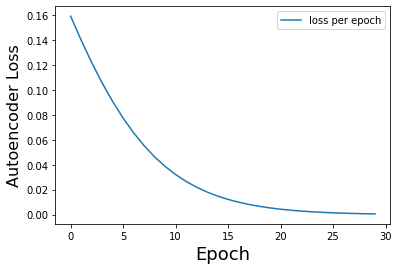

In [10]:
plt.plot(loss_values, label='loss per epoch')
plt.legend()
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Autoencoder Loss', fontsize=16)
plt.show()

## This concludes our tutorial. We hope you've enjoyed it!
